# Example of detrending and geostrophic flow calculation

In [1]:
push!(LOAD_PATH,"C:/JMB/DIVAnd.jl/src","."); using DIVAnd;cd("C:/JMB/DIVAnd.jl");cd("examples");using PyPlot
push!(LOAD_PATH,"C:/JMB/PhysOcean.jl/src","."); using PhysOcean

using NCDatasets
using DataStructures

# Load a more efficient version of sparse matrix multiplication
include(joinpath(Pkg.dir("DIVAnd"),"src","override_ssmult.jl"))

LoadError: [91mcould not open file C:\Users\jmbeckers\.julia\v0.6\DIVAnd\src\override_ssmult.jl[39m

## Bathmetry reading

In [2]:
bathname = "gebco_30sec_16.nc"

if !isfile(bathname)
    download("https://b2drop.eudat.eu/s/o0vinoQutAC7eb0/download",bathname)
else
    info("Bathymetry file already downloaded")
end

bathisglobal = true;

INFO: Bathymetry file already downloaded


## Bathymetry and grid preparation

In [3]:
dx = dy = 0.125

lonr = 27:dx:42
latr = 40:dy:47
depthr = [0., 5., 10, 15., 20, 25., 30, 40, 50, 60, 75, 85, 100, 125, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1750, 2000];


sz = (length(lonr),length(latr),length(depthr))

# correlation length in meters (in x, y, and z directions)

epsilon2=1

lenx = [2.5+depthr[k]/1000 for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]]

leny = [1.5+depthr[k]/1000 for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]]

lenz = [5+(depthr[min(k+1,sz[3])]-depthr[max(1,k-1)]) for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]]



mask,(pm,pn,po),(xi,yi,zi) = DIVAnd.DIVAnd_rectdom(lonr,latr,depthr)



bx,by,b = DIVAnd.load_bath(bathname,true,lonr,latr)



mask = falses(size(b,1),size(b,2),size(depthr,1))


    for j = 1:size(b,2)
        for i = 1:size(b,1)
        for k=1:size(depthr,1)
        mask[i,j,k] = b[i,j] >=zi[i,j,k]
        end
        end
    end



Look at topology

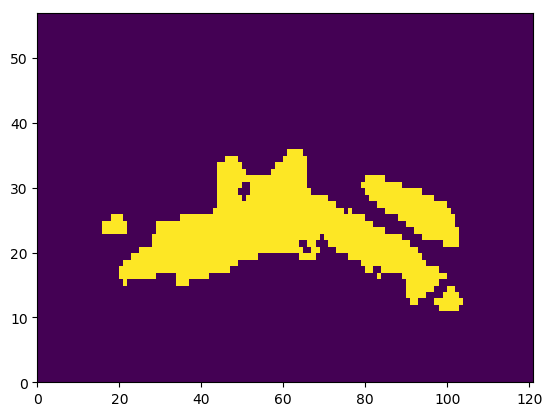

PyObject <matplotlib.collections.PolyCollection object at 0x0000000028B676A0>

In [4]:
pcolor(mask[:,:,end]')

Take out Marmara and Azov sea

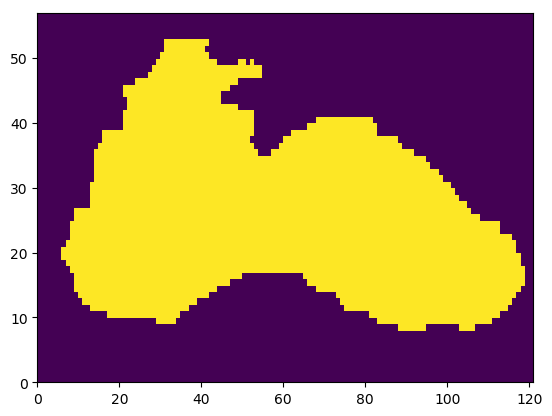

PyObject <matplotlib.collections.PolyCollection object at 0x000000003B858780>

In [5]:
# mask Azov and Marmara sea

sel1= (xi.>34.75) .& (yi.>45.10)
mask[sel1]=false
sel1= (xi.<29.5) .& (yi.<41.125)
mask[sel1]=false


pcolor(mask[:,:,1]')

Load data

In [6]:
value,lon,lat,depth,timeval,ids = DIVAnd.loadbigfile("Salinity.bigfile")
@show size(value)

x = "1929-11T11:52"
x = "1929-11T11:52"
size(value) = (4820520,)


(4820520,)

In [7]:
deepestdata=5500.0
lowestdata=14.0
highestdata=25.0

25.0

Select data (taking out Marmara and Azov sea)

size(value) = (4820520,)


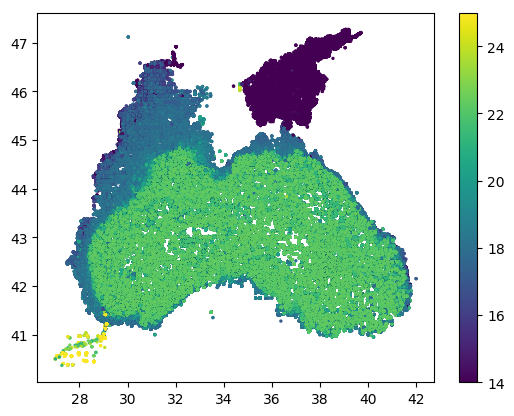

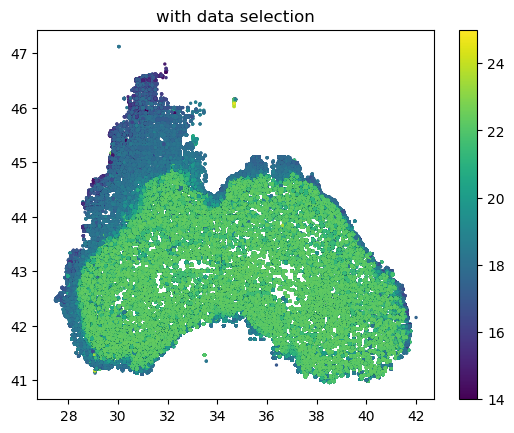

size(value) = (4731030,)


PyObject Text(0.5,1,u'with data selection')

In [8]:
sel=(value.>lowestdata) .& (value.<highestdata).& .~((lon.>34.75) .& (lat.>45.10)) .& 
.~((lon.<29.5) .& (lat.<41.125)) .& (depth.<deepestdata) .& (timeval .> DateTime(Date(1950)))

scatter(lon,lat,s=2,c=value,vmin=lowestdata,vmax=highestdata);colorbar()

@show(size(value))

value=value[sel]
lon=lon[sel]
lat=lat[sel]
depth=depth[sel]
timeval=timeval[sel]
ids=ids[sel]

@show(size(value))
figure()

scatter(lon,lat,s=2,c=value,vmin=lowestdata,vmax=highestdata);colorbar()
title("with data selection")

In [9]:
timeval[1]

1951-07-18T22:00:00

Observational error variance inflation factor

In [10]:
rdiag=1.0./DIVAnd.weight_RtimesOne((lon,lat,depth),(0.03,0.03,10));
mean(rdiag)

119.84195323423725

Useful functions to define new coordinates

In [11]:
function dayinyear(x); return Dates.value(Date(x)-Date(Dates.year(x))); end

function daysince1900(x); return Dates.value(Date(x)-Date(Dates.year(DateTime(1900)))); end

daysince1900 (generic function with 1 method)

Prepare a new analysis space: depth, day-in-a-year, time-in-days-from-1900

In [12]:
coordinatesfordetrending=(depth,dayinyear.(timeval),daysince1900.(timeval));
tmin,tmax=extrema(daysince1900.(timeval))
maskt,(pmt,pnt,pot),(xit,yit,zit) = DIVAnd.DIVAnd_rectdom(depthr,0:10:365,tmin:150:tmax);

In [13]:
sz=size(maskt)
lent3 = [15000+10*depthr[i] for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]]

lent2 = [150+depthr[i]/20 for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]]

lent1 = [5+(depthr[min(i+1,sz[1])]-depthr[max(1,i-1)]) for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]];

Two user functions defining the two scales. One is the trend analysis, the other the normal analysis.

In [14]:
function H1K1(data)
    K1d,s=DIVAnd.DIVAndrun(maskt,(pmt,pnt,pot),(xit,yit,zit),coordinatesfordetrending,data,(lent1,lent2,lent3),epsilon2*rdiag;moddim=[0,365,0]);
    #K1d,s=DIVAndrun(mask[1],pm[1],xi[1],x,data,len[1],epsilon2)    
    return K1d,data-DIVAnd_residual(s,K1d)
end
function H2K2(data)
    K2d,s=DIVAnd.DIVAndrun(mask,(pm,pn,po),(xi,yi,zi),(lon,lat,depth),data,(lenx,leny,lenz),epsilon2*rdiag);
    #K1d,s=DIVAndrun(mask[1],pm[1],xi[1],x,data,len[1],epsilon2)    
    return K2d,data-DIVAnd_residual(s,K2d)
end


H2K2 (generic function with 1 method)

Simple analysis for the trend space

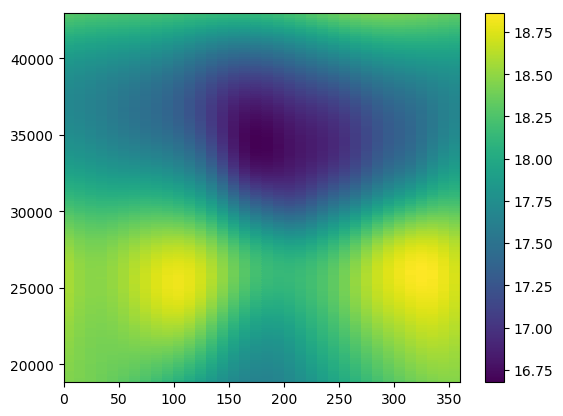

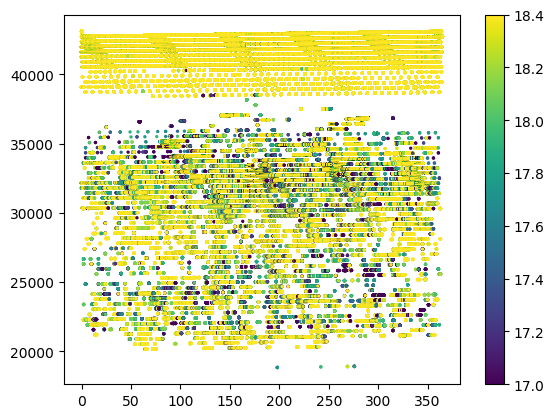

PyObject <matplotlib.colorbar.Colorbar object at 0x000000003C563FD0>

In [15]:
fdet,bidon=H1K1(value-mean(value));

pcolor(yit[1,:,:],zit[1,:,:],mean(value)+fdet[1,:,:]),colorbar()
figure()
scatter(coordinatesfordetrending[2],coordinatesfordetrending[3],s=2,c=value,vmin=17,vmax=18.4);colorbar()

Simple surface analysis

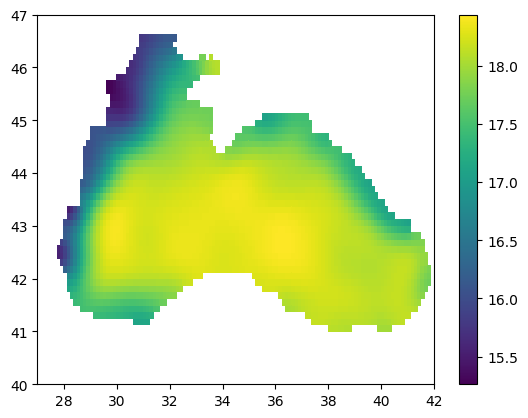

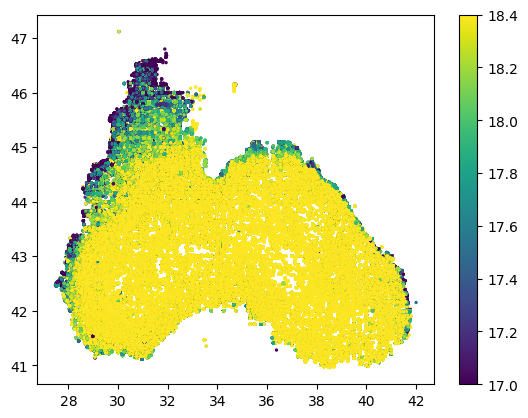

PyObject <matplotlib.colorbar.Colorbar object at 0x000000006E119860>

In [16]:
fsur,bidon=H2K2(value-mean(value))
fsurori=fsur;

figure()
pcolor(xi[:,:,1],yi[:,:,1],mean(value)+fsur[:,:,1]),colorbar()
figure()
scatter(lon,lat,s=2,c=value,vmin=17,vmax=18.4);colorbar()

## Now detrending via scale separation

In [17]:
?scaleseparation

search: scaleseparation



```
Phi1,H1Phi1,Phi2,H2Phi2=scaleseparation(K1andH1K1,K2andH2K2,d;niter=10)
```

# Input:

  * `K1andH1K1` : function, when called with a vector of data d, provides in return Kd,d-HK d ; i.e. the gridded analysis Kd an residual d-HKd for analysis tool 1
  * `K2andH2K2` : function, when called with a vector of data d, provides in return Kd,d-HK d ; i.e. the gridded analysis Kd an residual d-HKd for analysis tool 2
  * `d` : data array
  * `niter=` : optional keyword parameter defining the number of iterations used to invert I - H2K2 H1K2. Default is 10

# Output:

  * `Phi1` : analysis for tool 1 in which analysis of scale 2 is taken out
  * `H1Phi1`  : analysis at data locations for tool 1 in which analysis of scale 2 is taken out
  * `Phi2` : analysis for tool 2 in which analysis of scale 1 is taken out
  * `H2Phi2`  : analysis at data locations for tool 2 in which analysis of scale 1 is taken out

Tool to separate scales using two different analysis provided as two input functions

K1 should be related to the larger scales (or scales with high signal/noise ratios) and K2 to smaller or less energetic scales. If in doubt invert both and test with different number of iterations while looking at convergence.

see 	"Multi-scale optimal interpolation: application to DINEOF analysis spiced with a local optimal interpolation" 	http://hdl.handle.net/2268/165394

Here the two fields can have different supports (one could be a 3D analysis and the other one a season-depth analysis for example. Only the observational operators must provide the same data array at the output. In other words K1,HK1=K1andH1K1 should provide an output array HK1 of the same dimensions as the data array d and the output HK2 from K2,HK2=K2andH2K2


In [18]:
fdet,dd1,fsur,dd2=scaleseparation(H1K1,H2K2,value-mean(value);niter=3);

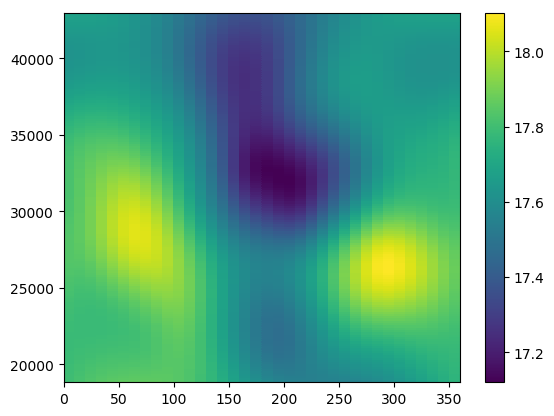

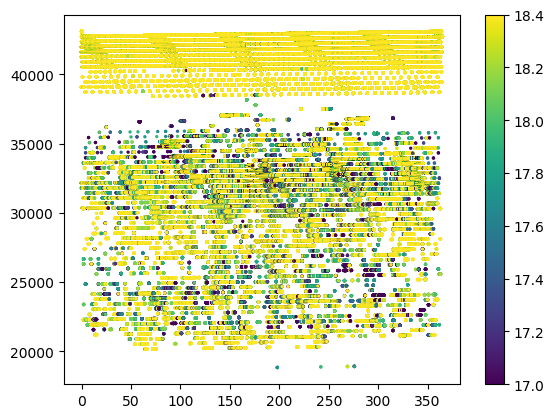

PyObject <matplotlib.colorbar.Colorbar object at 0x000000008B7124E0>

In [19]:
figure
pcolor(yit[1,:,:],zit[1,:,:],mean(value)+fdet[1,:,:]),colorbar()
figure()
scatter(coordinatesfordetrending[2],coordinatesfordetrending[3],s=2,c=value,vmin=17,vmax=18.4);colorbar()

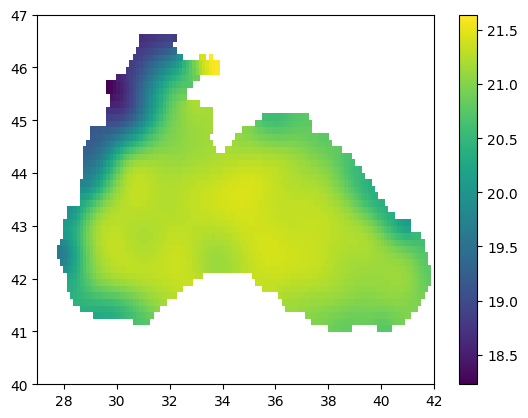

(PyObject <matplotlib.collections.PolyCollection object at 0x000000008BAFEB38>, PyObject <matplotlib.colorbar.Colorbar object at 0x000000008BC6F748>)

In [20]:
figure()
pcolor(xi[:,:,1],yi[:,:,1],mean(value)+fsur[:,:,1]),colorbar()



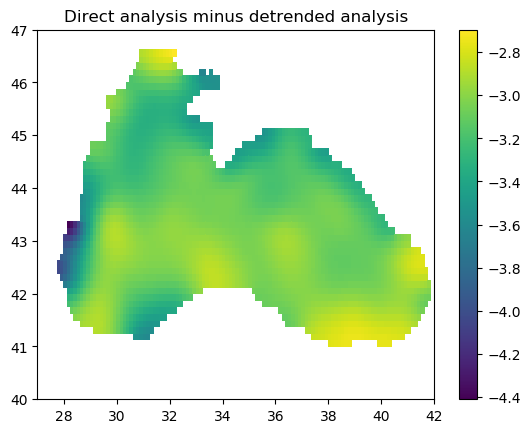

PyObject Text(0.5,1,u'Direct analysis minus detrended analysis')

In [21]:
figure()
pcolor(xi[:,:,1],yi[:,:,1],fsurori[:,:,1]-fsur[:,:,1]),colorbar()
title("Direct analysis minus detrended analysis")

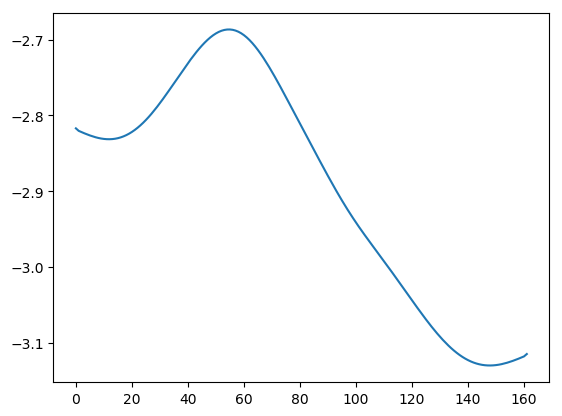

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000003063668>

In [22]:
plot((fdet[1,10,:]))

In [23]:
fsurs=deepcopy(fsur)+mean(value);

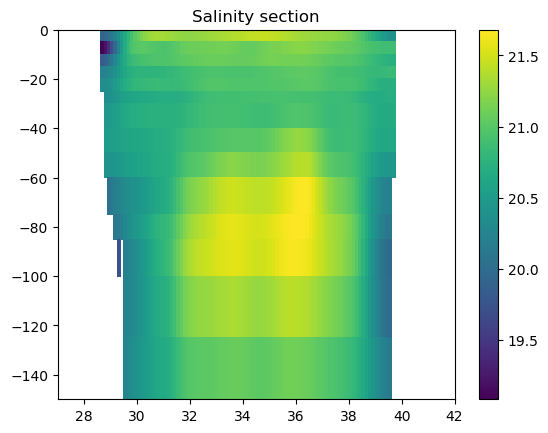

PyObject Text(0.5,1,u'Salinity section')

In [24]:
figure()
pcolor(xi[:,30,1:15],-zi[:,30,1:15],fsurs[:,30,1:15]),colorbar()
title("Salinity section")

## Now temperature


x = "1929-11T11:52"
size(value) = (4879574,)
size(value) = (4879574,)


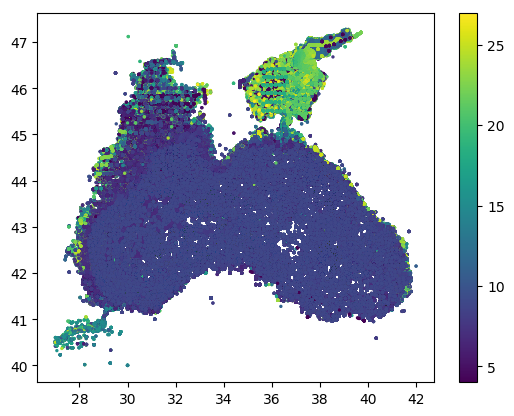

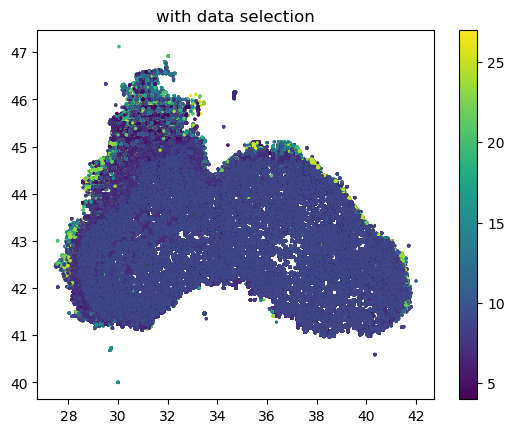

size(value) = (4764585,)


PyObject Text(0.5,1,u'with data selection')

In [25]:
value,lon,lat,depth,timeval,ids = DIVAnd.loadbigfile("Temperature.bigfile")
@show size(value)

lowestdata=4
highestdata=27
sel=(value.>lowestdata) .& (value.<highestdata).& .~((lon.>34.75) .& (lat.>45.10)) .& 
.~((lon.<29.5) .& (lat.<41.125)) .& (depth.<deepestdata) .& (timeval .> DateTime(Date(1950)))

scatter(lon,lat,s=2,c=value,vmin=lowestdata,vmax=highestdata);colorbar()

@show(size(value))

value=value[sel]
lon=lon[sel]
lat=lat[sel]
depth=depth[sel]
timeval=timeval[sel]
ids=ids[sel]

@show(size(value))
figure()

scatter(lon,lat,s=2,c=value,vmin=lowestdata,vmax=highestdata);colorbar()
title("with data selection")

In [26]:
coordinatesfordetrending=(depth,dayinyear.(timeval),daysince1900.(timeval));
#tmin,tmax=extrema(daysince1900.(timeval))
maskt,(pmt,pnt,pot),(xit,yit,zit) = DIVAnd.DIVAnd_rectdom(depthr,0:10:365,tmin:150:tmax);

In [27]:
function H1K1t(data)
    K1d,s=DIVAnd.DIVAndrun(maskt,(pmt,pnt,pot),(xit,yit,zit),coordinatesfordetrending,data,(lent1,lent2,lent3),epsilon2*rdiag;moddim=[0,365,0]);
    #K1d,s=DIVAndrun(mask[1],pm[1],xi[1],x,data,len[1],epsilon2)    
    return K1d,data-DIVAnd_residual(s,K1d)
end
function H2K2t(data)
    K2d,s=DIVAnd.DIVAndrun(mask,(pm,pn,po),(xi,yi,zi),(lon,lat,depth),data,(lenx,leny,lenz),epsilon2*rdiag);
    #K1d,s=DIVAndrun(mask[1],pm[1],xi[1],x,data,len[1],epsilon2)    
    return K2d,data-DIVAnd_residual(s,K2d)
end

H2K2t (generic function with 1 method)

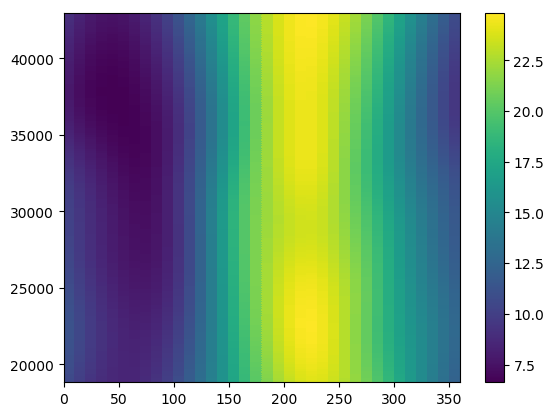

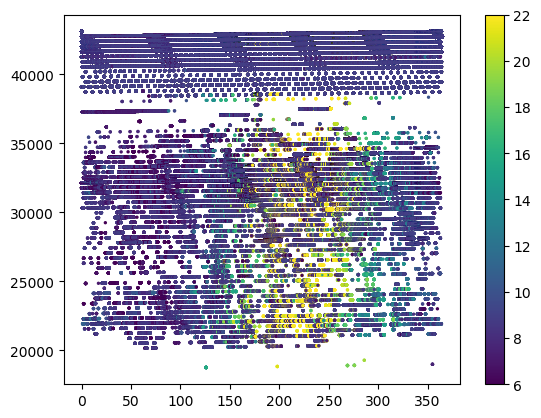

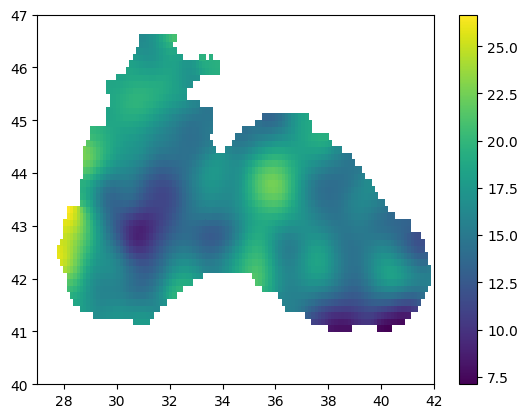

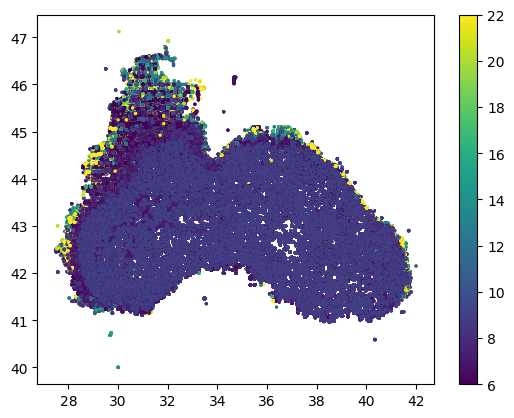

PyObject <matplotlib.colorbar.Colorbar object at 0x000000010C12C550>

In [28]:
rdiag=1.0./DIVAnd.weight_RtimesOne((lon,lat,depth),(0.03,0.03,10));
mean(rdiag)




fdet,bidon=H1K1t(value-mean(value));

pcolor(yit[1,:,:],zit[1,:,:],mean(value)+fdet[1,:,:]),colorbar()
figure()
scatter(coordinatesfordetrending[2],coordinatesfordetrending[3],s=2,c=value,vmin=6,vmax=22);colorbar()

fsur,bidon=H2K2t(value-mean(value))
fsurori=fsur;

figure()
pcolor(xi[:,:,1],yi[:,:,1],mean(value)+fsur[:,:,1]),colorbar()
figure()
scatter(lon,lat,s=2,c=value,vmin=6,vmax=22);colorbar()

In [29]:
fdett,dd1,fsurt,dd2=scaleseparation(H1K1t,H2K2t,value-mean(value);niter=3);

In [30]:
fsurt=fsurt+mean(value);

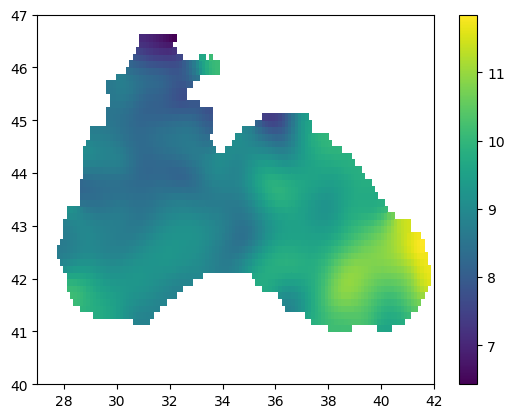

(PyObject <matplotlib.collections.PolyCollection object at 0x000000006E5C50B8>, PyObject <matplotlib.colorbar.Colorbar object at 0x000000010C2F5BA8>)

In [31]:
figure()
pcolor(xi[:,:,1],yi[:,:,1],fsurt[:,:,1]),colorbar()

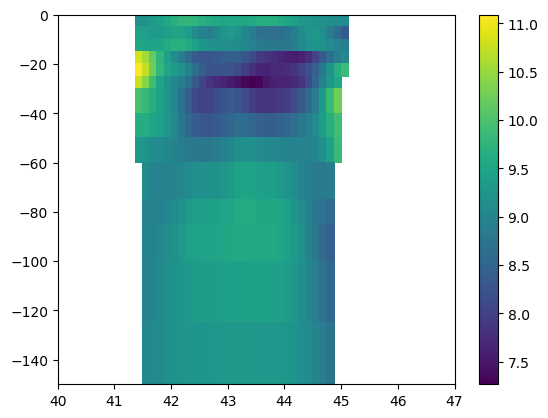

(PyObject <matplotlib.collections.PolyCollection object at 0x000000010C526278>, PyObject <matplotlib.colorbar.Colorbar object at 0x000000010C622BE0>)

In [32]:
pcolor(yi[80,:,1:15],-zi[80,:,1:15],fsurt[80,:,1:15]),colorbar()

## Geostrophic calculation using level of no motion

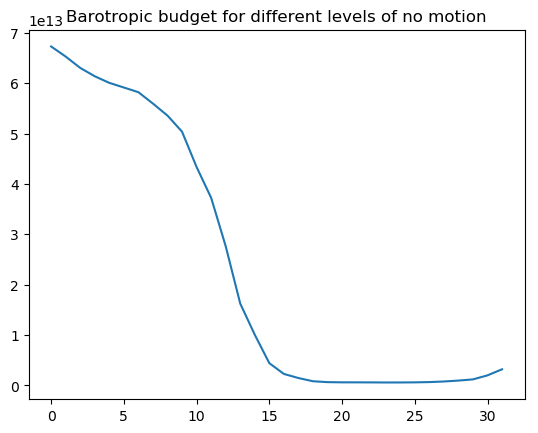

PyObject Text(0.5,1,u'Barotropic budget for different levels of no motion')

In [33]:
FN=zeros(size(depthr)[1])
dens=density.(fsurs,fsurt,0)-1025

for iz=1:size(depthr)[1]
    

    velocities,eta,Vflux=geostrophy(mask,dens,(pm,pn,po),(xi,yi,zi);znomotion=iz);
eta=eta-mean(eta);
    FN[iz]=mean(Vflux[1].^2)+mean(Vflux[2].^2)
end
figure

plot(FN)
title("Barotropic budget for different levels of no motion")


### Just an arbitrary level, to be corrected later

In [34]:
iz=indmin(FN)
@show iz

iz=15

velocities,eta,Vflux=geostrophy(mask,dens,(pm,pn,po),(xi,yi,zi);znomotion=iz);
eta=eta-mean(eta);



eta=DIVAnd_filter3(eta,NaN,10)



velocities,eta,Vflux=geostrophy(mask,dens,(pm,pn,po),(xi,yi,zi);ssh=eta)
    


iz = 24


(([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]), [0.

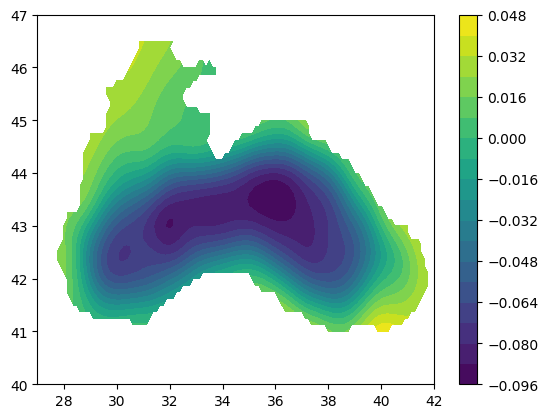

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000058B22F98>

In [35]:
contourf(xi[:,:,1],yi[:,:,1],eta+0*fsurt[:,:,1],20);colorbar()

Geostrophic calculationwith level of not motion provides non-zero global fluxes

In [36]:
mean(Vflux[1].^2)+mean(Vflux[2].^2)

1.7361628958534547e13

Try the correction term 

In [37]:
x = rand(1);
y = rand(1);
f = x

h=deepestpoint(mask,zi)
len=1
epsilon2=10000
rfluxes=0.000001

#Need to scale fluxes by f/g
gsf=(earthgravity.(yi)./coriolisfrequency.(yi))[:,:,1]
fi,s=DIVAndrun(mask[:,:,1],(pm[:,:,1],pn[:,:,1]),(xi[:,:,1],yi[:,:,1]),(x,y),f,len,epsilon2;topographyforfluxes=(gsf.*h,gsf.*h),fluxes=Vflux,epsfluxes=rfluxes,alphabc=1,alpha=[1, 0, 1]);

In [38]:
fim=deepcopy(fi);

In [39]:
fi[isnan.(fi)]=0

0

In [40]:
velafter,etaafter,Vfluxafter=geostrophy(mask,dens,(pm,pn,po),(xi,yi,zi);ssh=eta+fi);

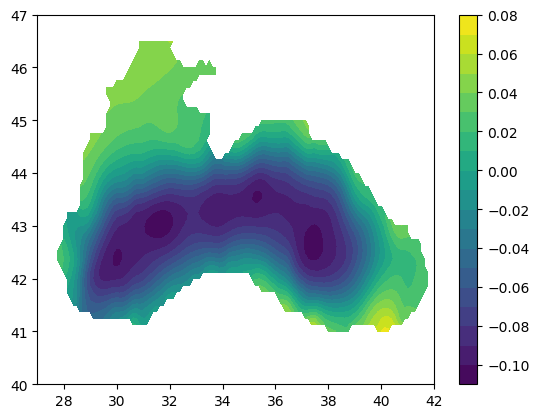

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000058F39BA8>

In [41]:
contourf(xi[:,:,1],yi[:,:,1],etaafter+0*fim,20);colorbar()

Now much lower global fluxes

In [42]:
mean(Vfluxafter[1].^2)+mean(Vfluxafter[2].^2)

2.7729039784073987e11

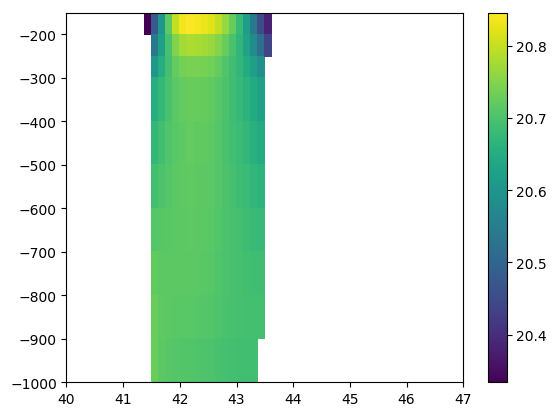

(PyObject <matplotlib.collections.PolyCollection object at 0x000000008B793828>, PyObject <matplotlib.colorbar.Colorbar object at 0x000000008B4C38D0>)

In [43]:
pcolor(yi[20,:,15:25],-zi[20,:,15:25],fsurs[20,:,15:25]),colorbar()